# Case Study: Sentiment Analysis and Topic Modelling combined on Presidential Speeches since 1989

In [864]:
import string

import numpy as np
import scipy
import pandas as pd
import re
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import gensim
from gensim.corpora import Dictionary
from gensim import models
from gensim.models import LdaModel
from gensim.matutils import corpus2csc

import html

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

## Load Data

In [865]:
data = pd.read_json('venv/data/presidential_speeches.json') # load data
data.sort_values(by=['date'], inplace=True) # sort by data
data.reset_index(drop=True, inplace=True) # reset index

## Preprocessing the data

In [866]:
# sort presidents to their parties
president_list = []
for i in range(len(data['president'].unique())):
    president_list.append(data['president'].unique()[i])
parties_list= ['Federalist', 'Democratic-Republican', 'National Republican', 'Democratic', 'Whig', 'Republican', 'Democratic (Union)']
sort_party = [0, 0, 1, 1, 1, 2, 3, 3, 4, 4, 3, 4, 4, 5, 3, 3, 6, 5, 5, 5, 5, 3, 5, 5, 5, 5, 3, 5, 5, 5, 3, 3, 5, 5, 3, 3, 5, 5, 3, 5, 3, 5, 3, 5, 3]
party = []
for i in range(len(sort_party)):
    party.append(parties_list[sort_party[i]])
data['party'] = pd.Series(dtype='string')
for i in range(len(president_list)):
    data['party'][data['president'] == president_list[i]] = party[i]
# assign each speech its respective era
data['era'] = pd.Series(dtype='string')
era_list = ['Early Republic', 'Jacksonian Democracy', 'Sectional Conflict', 'Gilded Age', 'Progressive Era', 'Depression and World Conflict', 'Social Change and Soviet Relations', 'Globalization']
for i in range(len(data)):
    if data['date'][i] < pd.Timestamp('1829-01-01T12'):
        data['era'][i] =  era_list[0]
    if pd.Timestamp('1829-01-01T12') <= data['date'][i] < pd.Timestamp('1853-01-01T12'):
        data['era'][i] = era_list[1]
    elif pd.Timestamp('1853-01-01T12') <= data['date'][i] < pd.Timestamp('1881-01-01T12'):
        data['era'][i] = era_list[2]
    elif pd.Timestamp('1881-01-01T12') <= data['date'][i] < pd.Timestamp('1897-01-01T12'):
        data['era'][i] = era_list[3]
    elif pd.Timestamp('1897-01-01T12') <= data['date'][i] < pd.Timestamp('1921-01-01T12'):
        data['era'][i] = era_list[4]
    elif pd.Timestamp('1921-01-01T12') <= data['date'][i] < pd.Timestamp('1961-01-01T12'):
        data['era'][i] = era_list[5]
    elif pd.Timestamp('1961-01-01T12') <= data['date'][i] < pd.Timestamp('1989-01-01T12'):
        data['era'][i] = era_list[6]
    elif pd.Timestamp('1989-01-01T12') <= data['date'][i]:
        data['era'][i] = era_list[7]

In [867]:
# Remove some noise
data['transcript'].replace(to_replace='(Applause.)', regex=True, value='', inplace=True)
data['transcript'].replace(to_replace='(Laughter.)', regex=True, value='', inplace=True)

In [868]:
for i in range(len(data)):
    data['transcript'][i] = data['transcript'][i].replace('\'', '')

C:\Users\Enno\AppData\Local\Temp/ipykernel_10832/1438919703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['transcript'][i] = data['transcript'][i].replace('\'', '')


The Following section is code adapted from Srikanth Shenoy and can be found under https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8 (accessed on 02/10/2023)

In [869]:
import string
import re
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup
from textblob import TextBlob
from unidecode import unidecode

In [870]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [871]:
def lemmatize_pos_tagged_text(text, lemmatizer, pos_tag_dict):
  sentences = nltk.sent_tokenize(text)
  new_sentences = []

  for sentence in sentences:
    sentence = sentence.lower()
    new_sentence_words = []
    #one pos_tuple for sentence
    pos_tuples = nltk.pos_tag(nltk.word_tokenize(sentence)) 

    for word_idx, word in enumerate(nltk.word_tokenize(sentence)):
      nltk_word_pos = pos_tuples[word_idx][1]
      wordnet_word_pos = pos_tag_dict.get(
                          nltk_word_pos[0].upper(), None)
      if wordnet_word_pos is not None:
        new_word = lemmatizer.lemmatize(word, wordnet_word_pos)
      else:
        new_word = lemmatizer.lemmatize(word)

      new_sentence_words.append(new_word)

    new_sentence = " ".join(new_sentence_words)
    new_sentences.append(new_sentence)

  return " ".join(new_sentences)

In [872]:

class NltkPreprocessingSteps:
  def __init__(self, X):
    self.X = X

    self.sw_nltk = stopwords.words('english')
    # remove some noise
    new_stopwords = ['<*>', 'q', 'yeah', 'guy', 'okay', 'ahead', 'mr', 'st', 'really', 'please', 'yes', 'sir', 'youn', 'yous', 'applause', 'lot']
    self.sw_nltk.extend(new_stopwords)
    self.sw_nltk.remove('not')

    self.pos_tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

    # '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~' 32 punctuations in python
    # we dont want to replace . first time around
    self.remove_punctuations = string.punctuation.replace('.','')

  def remove_html_tags(self):
    self.X = self.X.apply(
            lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return self

  def replace_diacritics(self):
    self.X = self.X.apply(
            lambda x: unidecode(x, errors="preserve"))
    return self

  def to_lower(self):
    self.X = np.apply_along_axis(lambda x: x.lower(), self.X)
    return self

  def expand_contractions(self):
    self.X = self.X.apply(
            lambda x: " ".join([contractions.fix(expanded_word) 
                        for expanded_word in x.split()]))
    return self

  def remove_numbers(self):
    self.X = self.X.apply(lambda x: re.sub(r'\d+', '', x))
    return self

  def replace_dots_with_spaces(self):
    self.X = self.X.apply(lambda x: re.sub("[.]", " ", x))
    return self

  def remove_punctuations_except_periods(self):
    self.X = self.X.apply(
                 lambda x: re.sub('[%s]' %
                  re.escape(self.remove_punctuations), '' , x))
    return self

  def remove_all_punctuations(self):
    self.X = self.X.apply(lambda x: re.sub('[%s]' %
                          re.escape(string.punctuation), '' , x))
    return self

  def remove_double_spaces(self):
    self.X = self.X.apply(lambda x: re.sub(' +', ' ', x))
    return self

  def fix_typos(self):
    self.X = self.X.apply(lambda x: str(TextBlob(x).correct()))
    return self

  def remove_stopwords(self):
    # remove stop words from token list in each column
    self.X = self.X.apply(
            lambda x: " ".join([ word for word in x.split() 
                     if word not in self.sw_nltk]) )
    return self

  def lemmatize(self):
    lemmatizer = WordNetLemmatizer()
    self.X = self.X.apply(lambda x: lemmatize_pos_tagged_text(
                           x, lemmatizer, self.pos_tag_dict))
    return self

  def get_processed_text(self):
    return self.X

In [873]:
# select only data since the start of the 'globalization era' == start of 1989
globalization_data = data.loc[data['era'] == 'Globalization']
globalization_data.reset_index(drop=True, inplace=True)

Preprocessing differently for Topic Modelling(TM) and Sentiment Analysis(SA) respectively, lemmatizing, removing punctuation and stopwords can reduce quality of SA, while TM requires it

In [874]:
# preprocess SA
SA_preproc = NltkPreprocessingSteps(globalization_data['transcript'])
SA_processed = \
    SA_preproc \
    .remove_html_tags()\
    .replace_diacritics()\
    .expand_contractions()\
    .remove_double_spaces()\
    .get_processed_text()

In [875]:
# preprocess TM
txt_preproc = NltkPreprocessingSteps(SA_processed)
TM_processed = \
    txt_preproc \
    .remove_numbers()\
    .remove_punctuations_except_periods()\
    .lemmatize()\
    .remove_all_punctuations()\
    .remove_stopwords()\
    .get_processed_text()

In [876]:
for i in range(len(TM_processed)):
    TM_processed[i] = list(TM_processed[i].split(' '))

In [877]:
# Look for Bigrams
from gensim.models import Phrases
bigram = Phrases(TM_processed, min_count=20)
for i in range(len(TM_processed)):
    for token in bigram[TM_processed[i]]:
        if '_' in token:
            TM_processed[i].append(token)

## Topic Modelling

In [878]:
# Bag of words modell and vectorization
dictionary = Dictionary(TM_processed)
# filter outlier, no topics above 50% occurrence rate or bellow 5 mentions
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in TM_processed]

In [879]:
from gensim.models.coherencemodel import CoherenceModel

In [886]:
# init parameters, get coherence score to determine best number of topics, 10 keywords per topic
chunksize = 100
passes = 30
iterations = 200
eval_every = None
coherence_list = []
for i in range(3, 11):
    num_topics = i
    model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )
    topics_temp = model.show_topics(
    num_topics=num_topics,
    num_words=10,
    log=False,
    formatted=False)
    cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    coherence_list.append(coherence)
    if i == 5:
        top = topics_temp
        mod = model

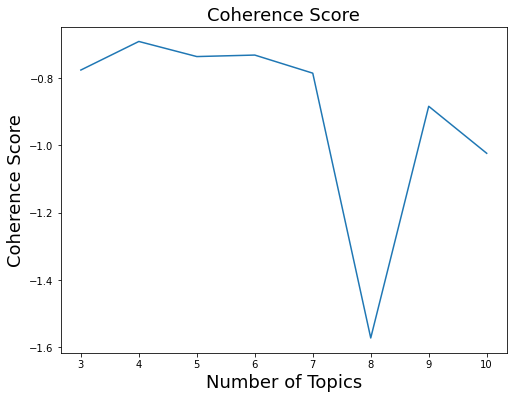

In [887]:
# plot Coherence score by topic numbers
plt.figure(figsize=(8, 6))
plt.plot(range(3,11), coherence_list)
plt.xlabel('Number of Topics', fontsize=18)
plt.ylabel("Coherence Score", fontsize=18)
plt.title('Coherence Score', fontsize=18)
plt.savefig('coherence.png', dpi = 100)

In [882]:
# assign class 'topics' to keep track of sentiment data per topic
class Topic:
    def __init__(self, topic_list):
        self.topics = topic_list
        self.neg = 0
        self.neu = 0
        self.pos = 0
        self.sent_compound = 0
        self.sent_avg = 0
    def sentiment(self, sentiment, score):
        if sentiment == 'neg':
            self.neg += 1
        elif sentiment == 'pos':
            self.pos += 1
        elif sentiment == 'neu':
            self.neu += 1
        self.sent_compound += score
        self.sent_avg = self.sent_compound/(self.neg + self.pos + self.neu)

In [888]:
# print topics found 
for topic_id, topic in top:
    print([word for word, _ in topic])

['election', 'vote', 'black', 'truth', 'win', 'justice', 'violence', 'white', 'man', 'republican']
['tax', 'tonight', 'cut', 'reform', 'company', 'bill', 'health_care', 'drug', 'education', 'republican']
['ukraine', 'putin', 'russia', 'russian', 'nato', 'sanction', 'ukrainian', 'russias', 'europe', 'poland']
['afghanistan', 'troop', 'afghan', 'taliban', 'ally', 'mission', 'iraq', 'terrorist', 'partner', 'international']
['test', 'governor', 'deal', 'case', 'percent', 'money', 'covid', 'area', 'senator', 'china']


In [889]:
# Intertopic Distance Map
import pyLDAvis.gensim as gensimvis
import pyLDAvis

vis_data_lda = gensimvis.prepare(mod, corpus, dictionary)
#pyLDAvis.save_html(vis_data_lda,'lda_all.html')
pyLDAvis.display(vis_data_lda)

In [890]:
# initialize topic class split by republican and democratic
topics_list_republican = []
topics_list_democratic = []
for topic_id, topic in top:
    topics_list_democratic.append(Topic([word for word, _ in topic]))
    topics_list_republican.append(Topic([word for word, _ in topic]))

## Sentiment Analysis

In [891]:
# split by sentence to get sentiment of each sentence
for i in range(len(SA_processed)):
    SA_processed[i] = nltk.sent_tokenize(SA_processed[i])

In [892]:
# get vader sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
globalization_data['vader'] =pd.Series(dtype='object')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Enno\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Enno\AppData\Local\Temp/ipykernel_10832/758829595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalization_data['vader'] =pd.Series(dtype='object')


In [893]:
# sentiment analysis of each sentence, polarity score is saved
vader_model = SentimentIntensityAnalyzer()
for i in range(len(SA_processed)):
    score_list = []
    for j in range(len(SA_processed[i])):
        score_list.append(vader_model.polarity_scores(SA_processed[i][j])['compound'])
    globalization_data['vader'][i] = score_list

C:\Users\Enno\AppData\Local\Temp/ipykernel_10832/1757868817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalization_data['vader'][i] = score_list


In [894]:
# new column to save sentiment
globalization_data['sentiment'] =pd.Series(dtype='object')

C:\Users\Enno\AppData\Local\Temp/ipykernel_10832/3630842766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalization_data['sentiment'] =pd.Series(dtype='object')


In [895]:
# assign sentiment based on polarity score, if > 0.001 == positive, if < -0.001 == negative, else neutral 
for i in range(len(globalization_data)):
    sentiment_list = []
    for j in range(len(globalization_data['vader'][i])):
        if globalization_data['vader'][i][j] > 0.001:
            sentiment_list.append('pos')
        elif -0.001 <= globalization_data['vader'][i][j] <= 0.001:
            sentiment_list.append('neu')
        elif globalization_data['vader'][i][j] < -0.001:
            sentiment_list.append('neg')
    globalization_data['sentiment'][i] = sentiment_list

C:\Users\Enno\AppData\Local\Temp/ipykernel_10832/1991532719.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globalization_data['sentiment'][i] = sentiment_list


In [896]:
# look for common elements in two lists 
def common_member(list1, list2):
    temp1 = set(list1)
    temp2 = set(list2)
    if len(temp1.intersection(temp2)) > 0:
        return True 
    return False

## Combining SA and TM

In [897]:
for i in range(len(SA_processed)):
    # lemmatize, remove stopwords and punctuation of each individual sentence in speeches
    txt_preproc = NltkPreprocessingSteps(pd.Series(SA_processed[i]))
    post_lemmatize = \
        txt_preproc \
        .remove_numbers()\
        .remove_punctuations_except_periods()\
        .lemmatize()\
        .remove_all_punctuations()\
        .remove_stopwords()\
        .get_processed_text()
    for l in range(len(post_lemmatize)):
        post_lemmatize[l] = post_lemmatize[l].split(' ')
    # find bigrams
    bigram = Phrases(post_lemmatize, min_count=20)
    for j in range(len(post_lemmatize)):
        for token in bigram[post_lemmatize[j]]:
            if '_' in token:
                post_lemmatize[j].append(token)
    # if a lemma of a sentence is matched to one of topic keywords, topic sentiment counter goes up by respective identified sentiment of its sentence, polarity score gets added and averaged
    if i in globalization_data[globalization_data['party'] == 'Republican'].index: # split for republican
        for k in range(len(post_lemmatize)):
            for topic in topics_list_republican:
                if common_member(topic.topics, post_lemmatize[k]):
                    topic.sentiment(globalization_data['sentiment'][i][k], globalization_data['vader'][i][k])
    if i in globalization_data[globalization_data['party'] == 'Democratic'].index: # split for democratic
        for k in range(len(post_lemmatize)):
            for topic in topics_list_democratic:
                if common_member(topic.topics, post_lemmatize[k]):
                    topic.sentiment(globalization_data['sentiment'][i][k], globalization_data['vader'][i][k])

## Plot Results

loosely based on https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py accessed on 03/10/23
topics are going to be different for each run 

<function matplotlib.pyplot.show(close=None, block=None)>

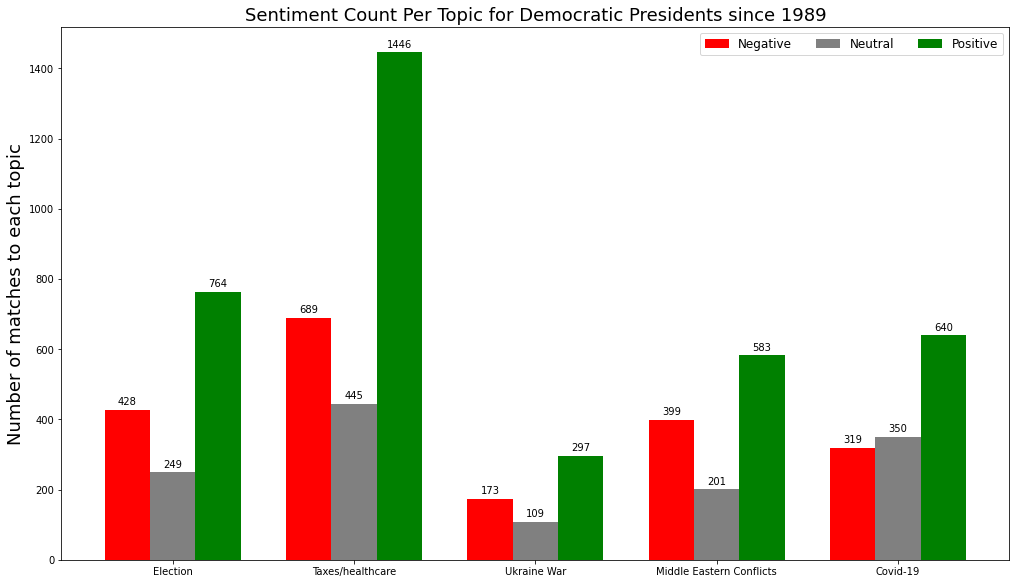

In [909]:
# plot count of sentiment for each topic for democratic party
topic_names = ('Election', 'Taxes/healthcare', 'Ukraine War', 'Middle Eastern Conflicts', 'Covid-19')

sentiment_democratic = {
    'Negative': (topics_list_democratic[0].neg, topics_list_democratic[1].neg, topics_list_democratic[2].neg, topics_list_democratic[3].neg, topics_list_democratic[4].neg),
    'Neutral': (topics_list_democratic[0].neu, topics_list_democratic[1].neu, topics_list_democratic[2].neu, topics_list_democratic[3].neu, topics_list_democratic[4].neu),
    'Positive': (topics_list_democratic[0].pos, topics_list_democratic[1].pos, topics_list_democratic[2].pos, topics_list_democratic[3].pos, topics_list_democratic[4].pos)
}

x = np.arange(len(topic_names))
width = 0.25  
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
colors = ['red', 'grey', 'green']
fig.set_size_inches(14, 8)
for attribute, sent in sentiment_democratic.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, sent, width, label=attribute, color=colors[multiplier])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of matches to each topic', fontsize=18)
ax.set_title('Sentiment Count Per Topic for Democratic Presidents since 1989', fontsize=18)
ax.set_xticks(x + width, topic_names)
ax.legend(loc='upper right', ncols=3, fontsize=12)
fig.savefig('SentimentOnTopicsTotalDemocratic.png', dpi=100)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

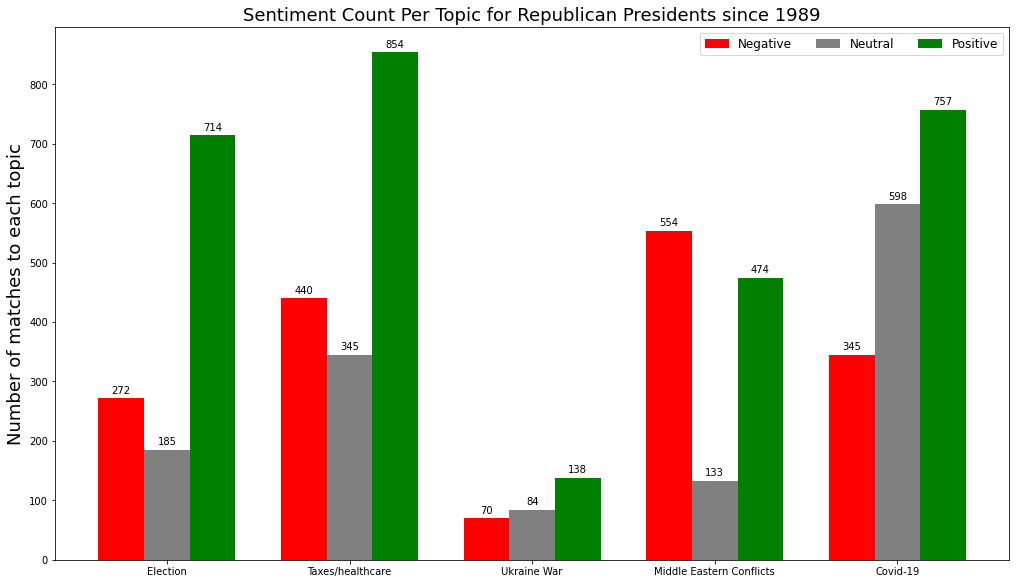

In [908]:
# plot count of sentiment for each topic for republican party
topic_names = ('Election', 'Taxes/healthcare', 'Ukraine War', 'Middle Eastern Conflicts', 'Covid-19')
sentiment_republican = {
    'Negative': (topics_list_republican[0].neg, topics_list_republican[1].neg, topics_list_republican[2].neg, topics_list_republican[3].neg, topics_list_republican[4].neg),
    'Neutral': (topics_list_republican[0].neu, topics_list_republican[1].neu, topics_list_republican[2].neu, topics_list_republican[3].neu, topics_list_republican[4].neu),
    'Positive': (topics_list_republican[0].pos, topics_list_republican[1].pos, topics_list_republican[2].pos, topics_list_republican[3].pos, topics_list_republican[4].pos)
}

x = np.arange(len(topic_names))
width = 0.25  
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
colors = ['red', 'grey', 'green']
fig.set_size_inches(14, 8)
for attribute, sent in sentiment_republican.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, sent, width, label=attribute, color=colors[multiplier])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of matches to each topic', fontsize=18)
ax.set_title('Sentiment Count Per Topic for Republican Presidents since 1989', fontsize=18)
ax.set_xticks(x + width, topic_names)
ax.legend(loc='upper right', ncols=3, fontsize=12)
fig.savefig('SentimentOnTopicsRepublican.png', dpi=100)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

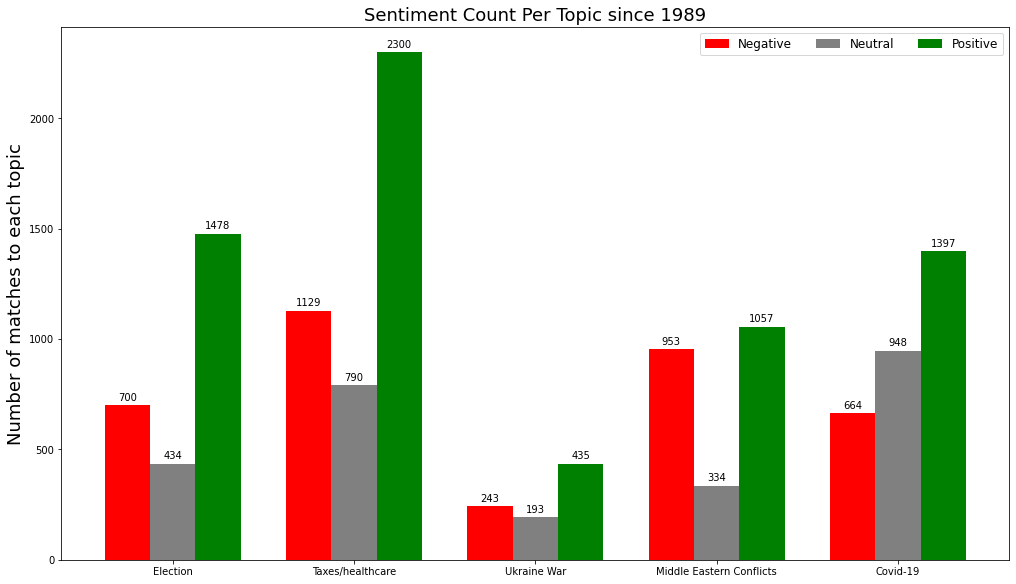

In [907]:
# plot count of sentiment for each topic total
topic_names = ('Election', 'Taxes/healthcare', 'Ukraine War', 'Middle Eastern Conflicts', 'Covid-19')

sentiment = {
    'Negative': (tuple(map(sum, zip(sentiment_republican['Negative'], sentiment_democratic['Negative'])))),
    'Neutral': (tuple(map(sum, zip(sentiment_republican['Neutral'], sentiment_democratic['Neutral'])))),
    'Positive': (tuple(map(sum, zip(sentiment_republican['Positive'], sentiment_democratic['Positive']))))
}

x = np.arange(len(topic_names))
width = 0.25  
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
colors = ['red', 'grey', 'green']
fig.set_size_inches(14, 8)
for attribute, sent in sentiment.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, sent, width, label=attribute, color=colors[multiplier])
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of matches to each topic', fontsize=18)
ax.set_title('Sentiment Count Per Topic since 1989', fontsize=18)
ax.set_xticks(x + width, topic_names)
ax.legend(loc='upper right', ncols=3, fontsize=12)
fig.savefig('SentimentOnTopicsTotal.png', dpi=100)
plt.show

In [906]:
# average polarity score
for i in range(5):
    print('Average Polarity score of Democratic presidents for Topic ' + str(i) + ':', topics_list_democratic[i].sent_avg)
for i in range(5):
    print('Average Polarity score of Republican presidents for Topic ' + str(i) + ':', topics_list_republican[i].sent_avg)

Average Polarity score of Democratic presidents for Topic 0: 0.1387303261623872
Average Polarity score of Democratic presidents for Topic 1: 0.1843096899224806
Average Polarity score of Democratic presidents for Topic 2: 0.09914715025906726
Average Polarity score of Democratic presidents for Topic 3: 0.0792172442941673
Average Polarity score of Democratic presidents for Topic 4: 0.13942513368983958
Average Polarity score of Republican presidents for Topic 0: 0.2444970111016231
Average Polarity score of Republican presidents for Topic 1: 0.15304234289200747
Average Polarity score of Republican presidents for Topic 2: 0.14920273972602743
Average Polarity score of Republican presidents for Topic 3: -0.07097915590008605
Average Polarity score of Republican presidents for Topic 4: 0.13344458823529431
